# Coursework Template

**Dependencies and imports**

This can take a minute...

In [ ]:
# !pip install swig
# 1pip install --upgrade rldurham

In [1]:
# %pip install optuna
import optuna
import torch
import rldurham as rld
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import copy
device = torch.device("cpu")
from collections import deque
import torch.optim as optim
import random

**Define Actor, Critic and System Networks**

In [2]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, fc1=400, fc2=300):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, fc1)
        self.l2 = nn.Linear(fc1, fc2)
        self.l3 = nn.Linear(fc2, action_dim)



    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return torch.tanh(self.l3(a)) # max_action = 1 so no need to multiply
     
class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1=400, fc2=300):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc1)
        self.l2 = nn.Linear(fc1, fc2)
        self.l3 = nn.Linear(fc2, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc1)
        self.l5 = nn.Linear(fc1, fc2)
        self.l6 = nn.Linear(fc2, 1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xa))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)

        return x1, x2
    
class SysModel(nn.Module):
    def __init__(self, state_dim, action_dim, fc1=400, fc2=300):
        super(SysModel, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, fc1)
        self.l2 = nn.Linear(fc1, fc2)
        self.l3 = nn.Linear(fc2, state_dim)


    def forward(self, state, action):
        """Build a system model to predict the next state at a given state."""
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        return x1

In [ ]:
class TD3_FORK:
    def __init__(
        self,env,
        gamma = 0.99, #discount factor
        lr_actor = 3e-4,
        lr_critic = 3e-4,
        lr_sysmodel = 3e-4,
        batch_size = 100, # minibatch size for replay buffer sampling
        buffer_capacity = 1000000, # replay buffer capacity
        tau = 0.02,  # soft update weight / interpolant
        policy_noise=0.2, # Policy noise
        std_noise = 0.1, # Exploration noise
        noise_clip=0.5, # Clips policy noise
        policy_freq=2 # Policy delay
    ):
        self.device = torch.device("cpu")
        self.env = env
        self.create_actor()
        self.create_critic()
        self.create_sysmodel()
        self.act_opt = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.sys_opt = optim.Adam(self.sysmodel.parameters(), lr=lr_sysmodel)
        self.set_weights() # initialise target models
        self.replay_memory_buffer = deque(maxlen = buffer_capacity)
        self.replay_memory_bufferd_dis = deque(maxlen = buffer_capacity)
        self.batch_size = batch_size
        self.tau = tau
        self.policy_freq = policy_freq
        self.gamma = gamma
        self.upper_bound = self.env.action_space.high[0] #action space upper bound
        self.lower_bound = self.env.action_space.low[0]  #action space lower bound
        self.obs_upper_bound = self.env.observation_space.high[0] #state space upper bound
        self.obs_lower_bound = self.env.observation_space.low[0]  #state space lower bound
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.std_noise = std_noise
    
    def create_actor(self):
        self.actor = Actor(obs_dim, act_dim).to(self.device)
        self.actor_target = Actor(obs_dim, act_dim).to(self.device)

    def create_critic(self):
        self.critic = Critic(obs_dim, act_dim).to(self.device)
        self.critic_target = Critic(obs_dim, act_dim).to(self.device)

    def create_sysmodel(self):
        self.sysmodel = SysModel(obs_dim, act_dim).to(self.device)

    def set_weights(self):
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
    def add_to_replay_memory(self, transition, buffername):
        #add samples to replay memory
        buffername.append(transition)

    def get_random_sample_from_replay_mem(self, buffername):
        #random samples from replay memory
        random_sample = random.sample(buffername, self.batch_size)
        return random_sample


    def learn_and_update_weights_by_replay(self,training_iterations, weight, totrain):
        """
        Train actor, critic and system networks. Apply delayed policy updates
        Args:
            training_iterations (int): The number of times batches from replay buffer are sampled and used to update network weights
            weight (float): Soft scheduler used to slow learning after convergence
            totrain (int): Flag for applying policy updates
        
        Returns: 
            float: System model MSE loss
        """
       
        if len(self.replay_memory_buffer) < 8e3:
            return 1
        
        for it in range(training_iterations):
            mini_batch = self.get_random_sample_from_replay_mem(self.replay_memory_buffer)
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            add_reward_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[4] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[5] for i in mini_batch]).astype(np.uint8)).float().to(self.device)

            
            # Obtain target actions for target actor
            target_actions = self.actor_target(next_state_batch)
            # Add policy noise
            offset_noises = torch.FloatTensor(action_batch.shape).data.normal_(0, self.policy_noise).to(self.device)

            # Clip policy noise
            offset_noises = offset_noises.clamp(-self.noise_clip, self.noise_clip)
            # Apply policy noise to target actions
            target_actions = (target_actions + offset_noises).clamp(self.lower_bound, self.upper_bound)

            #Compute the target Q value
            Q_targets1, Q_targets2 = self.critic_target(next_state_batch, target_actions)
            Q_targets = torch.min(Q_targets1, Q_targets2)
            Q_targets = reward_batch + self.gamma * Q_targets * (1 - done_list)

            #Compute current Q estimates
            current_Q1, current_Q2 = self.critic(state_batch, action_batch)
            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, Q_targets.detach()) + F.mse_loss(current_Q2, Q_targets.detach())
            # Optimise the critics
            self.crt_opt.zero_grad()
            critic_loss.backward()
            self.crt_opt.step()

            self.soft_update_target(self.critic, self.critic_target)

            predict_next_state = self.sysmodel(state_batch, action_batch) * (1-done_list)
            next_state_batch = next_state_batch * (1 -done_list)
            sysmodel_loss = F.mse_loss(predict_next_state, next_state_batch.detach())
            self.sys_opt.zero_grad()
            sysmodel_loss.backward()
            self.sys_opt.step()
        
            s_flag = 1 if sysmodel_loss.item() < 0.020  else 0

            if it % self.policy_freq == 0 and totrain == 1:
                actions = self.actor(state_batch)
                actor_loss1,_ = self.critic_target(state_batch, actions)
                actor_loss1 =  actor_loss1.mean()
                actor_loss =  - actor_loss1 

                if s_flag == 1:
                    p_actions = self.actor(state_batch)
                    p_next_state = self.sysmodel(state_batch, p_actions).clamp(self.obs_lower_bound,self.obs_upper_bound)

                    p_actions2 = self.actor(p_next_state.detach()) * self.upper_bound
                    actor_loss2,_ = self.critic_target(p_next_state.detach(), p_actions2)
                    actor_loss2 = actor_loss2.mean() 

                    p_next_state2= self.sysmodel(p_next_state.detach(), p_actions2).clamp(self.obs_lower_bound,self.obs_upper_bound)
                    p_actions3 = self.actor(p_next_state2.detach()) * self.upper_bound
                    actor_loss3,_ = self.critic_target(p_next_state2.detach(), p_actions3)
                    actor_loss3 = actor_loss3.mean() 

                    actor_loss_final =  actor_loss - weight * (actor_loss2) - 0.5 *  weight * actor_loss3
                else:
                    actor_loss_final =  actor_loss

                self.act_opt.zero_grad()
                actor_loss_final.backward()
                self.act_opt.step()

                #Soft update target models
                self.soft_update_target(self.actor, self.actor_target)
                
        return sysmodel_loss.item()
    
    def soft_update_target(self,local_model,target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Args:
            local_model (PyTorch model): model weights will be copied from
            target_model (PyTorch model): model weights will be copied to
            tau (float): interpolation parameter (soft update weight)
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def policy(self,state):
        """select action according to policy (actor)"""
        state = torch.FloatTensor(state.reshape(1, -1)).to(device) # change to state?
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(state).cpu().data.numpy()
        self.actor.train()
        # Adding noise to action
        shift_action = np.random.normal(0, self.std_noise, size=self.env.action_space.shape[0])
        sampled_actions = (actions + shift_action)
        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        return np.squeeze(legal_action)

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


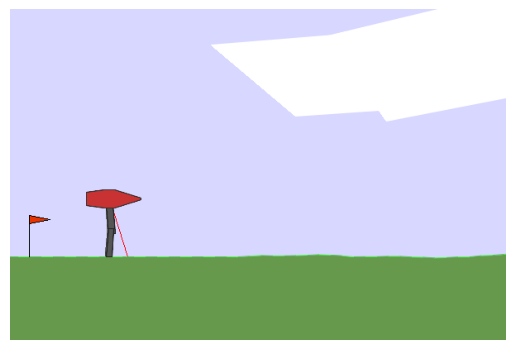

In [9]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="hardcore-videos-FORK-easy",              # folder for videos
    video_prefix="hdtk63-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

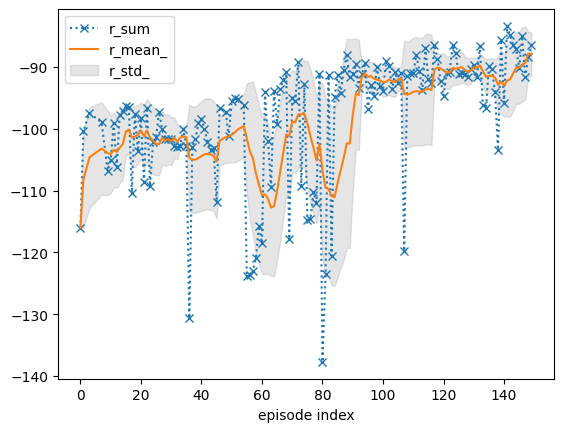

Ep: 150, ep timesteps: 129, fell over: 143, ep reward: -86.3821909676255, weight: 1.0, replay buffer length: 29820
Ep: 151, ep timesteps: 190, fell over: 144, ep reward: -75.03424909630687, weight: 1.0, replay buffer length: 30010
Ep: 152, ep timesteps: 136, fell over: 145, ep reward: -85.83391344489134, weight: 1.0, replay buffer length: 30146
Ep: 153, ep timesteps: 1754, fell over: 146, ep reward: -100.77643285151134, weight: 1.0, replay buffer length: 31900


KeyboardInterrupt: 

In [10]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

max_action = 1
batch_size = 207 # Tuned
agent = TD3_FORK(env, batch_size=batch_size)

max_episodes = 1500
max_timesteps = 2000

total_timesteps = 0
timesteps = 0
# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

ep_reward_list = []
sys_loss = 0
numtrainedexp = 0
save_time = 0
expcount = 0
totrain = 0
fell_over = 0

# training procedure
for episode in range(max_episodes):
    
    # recording statistics and video can be switched on and off (video recording is slow!)
    env.info = episode % 1 == 0   # track every x episodes (usually tracking every episode is fine)
    env.video = episode == 301  # record videos every x episodes (set BEFORE calling reset!)

    # reset for new episode
    observation, info = env.reset()
    temp_replay_buffer = []
    
    episodic_reward = 0
    timesteps = 0
    # run episode
    for t in range(max_timesteps):
        # select the agent action
        if total_timesteps < 10000:
            action = env.action_space.sample()
        else:
            action = agent.policy(np.array(observation))
        
        last_observation = observation
        # take action in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        episodic_reward += reward
        if reward == -100: # Fell over
            add_reward = -1
            reward = -10 # Tuned
            fell_over += 1
            expcount += 1
        else:
            add_reward = 0
            reward *= 5 # Tuned
            
         # check whether done
        done = terminated or truncated
        
        # Remember
        temp_replay_buffer.append((last_observation, action, reward, add_reward, observation, done))
        
        total_timesteps += 1
        timesteps += 1
        
        # stop episode
        if done or timesteps == 2000:
            if add_reward == -1 or episodic_reward < 250:
                totrain = 1
                for temp in temp_replay_buffer:
                    agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
            elif expcount > 0 and np.random.rand() > 0.5:
                totrain = 1
                expcount -= 10
                for temp in temp_replay_buffer:
                    agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
            break
            
        
            
        
    # track and plot statistics
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(info, r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
    
    ep_reward_list.append(episodic_reward)
    
    weight = 1 - np.clip(np.mean(ep_reward_list[-100:])/300, 0, 1)
    print(f"Ep: {episode+1}, ep timesteps: {timesteps}, fell over: {fell_over}, ep reward: {episodic_reward}, weight: {weight}, replay buffer length: {len(agent.replay_memory_buffer)}")
    if totrain == 1:
        sys_loss = agent.learn_and_update_weights_by_replay(timesteps, weight, totrain)
    else:
        sys_loss = agent.learn_and_update_weights_by_replay(100, weight, totrain)
    totrain = 0
    
    
    
    
# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file (for coursework)
# env.write_log(folder="logs", file="hdtk63-agent-log.txt")  # replace xxxx00 with your username

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

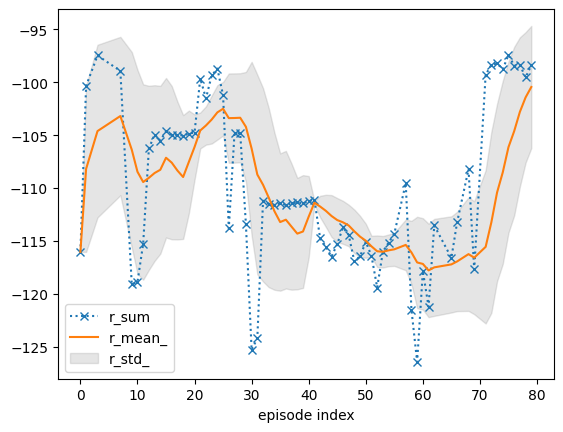

mean episode reward: -107.81299259613428 batch size 207 b_len 984
Ep: 80, ep timesteps: 87, fell over: 70, ep reward: -98.38520250826588, weight: 1.0, replay buffer length: 24293
Training iterations 87
Ep: 81, ep timesteps: 80, fell over: 71, ep reward: -100.03933977034194, weight: 1.0, replay buffer length: 24373
Training iterations 80
Ep: 82, ep timesteps: 86, fell over: 72, ep reward: -97.72002118822036, weight: 1.0, replay buffer length: 24459
Training iterations 86
Ep: 83, ep timesteps: 2000, fell over: 72, ep reward: -42.771173726217626, weight: 1.0, replay buffer length: 26459
Training iterations 2000


In [ ]:
# %pip install optuna
import optuna
import torch
import rldurham as rld
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import copy
device = torch.device("cpu")
from collections import deque
import torch.optim as optim
import random

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, fc1=400, fc2=300):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, fc1)
        self.l2 = nn.Linear(fc1, fc2)
        self.l3 = nn.Linear(fc2, action_dim)



    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return torch.tanh(self.l3(a)) # max_action = 1 so no need to multiply
     
class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1=400, fc2=300):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc1)
        self.l2 = nn.Linear(fc1, fc2)
        self.l3 = nn.Linear(fc2, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc1)
        self.l5 = nn.Linear(fc1, fc2)
        self.l6 = nn.Linear(fc2, 1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xa))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)

        return x1, x2
    
class SysModel(nn.Module):
    def __init__(self, state_dim, action_dim, fc1=400, fc2=300):
        super(SysModel, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, fc1)
        self.l2 = nn.Linear(fc1, fc2)
        self.l3 = nn.Linear(fc2, state_dim)


    def forward(self, state, action):
        """Build a system model to predict the next state at a given state."""
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        return x1
    
class TD3_FORK:
    def __init__(
        self,env,
        gamma = 0.99, #discount factor
        lr_actor = 3e-4,
        lr_critic = 3e-4,
        lr_sysmodel = 3e-4,
        batch_size = 100,
        buffer_capacity = 1000000,
        tau = 0.02,  #target network update factor
        policy_noise=0.2, 
        std_noise = 0.1,
        noise_clip=0.5,
        policy_freq=2, #target network update period
        b_len = 1e4
    ):
        self.device = torch.device("cpu")
        self.env = env
        self.create_actor()
        self.create_critic()
        self.create_sysmodel()
        self.act_opt = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.sys_opt = optim.Adam(self.sysmodel.parameters(), lr=lr_sysmodel)
        self.set_weights()
        self.replay_memory_buffer = deque(maxlen = buffer_capacity)
        self.replay_memory_bufferd_dis = deque(maxlen = buffer_capacity)
        self.batch_size = batch_size
        self.tau = tau
        self.policy_freq = policy_freq
        self.gamma = gamma
        self.upper_bound = self.env.action_space.high[0] #action space upper bound
        self.lower_bound = self.env.action_space.low[0]  #action space lower bound
        self.obs_upper_bound = self.env.observation_space.high[0] #state space upper bound
        self.obs_lower_bound = self.env.observation_space.low[0]  #state space lower bound
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.std_noise = std_noise
        self.b_len = b_len
    
    def create_actor(self):
        self.actor = Actor(24, 4).to(self.device)
        self.actor_target = Actor(24, 4).to(self.device)

    def create_critic(self):
        self.critic = Critic(24, 4).to(self.device)
        self.critic_target = Critic(24, 4).to(self.device)

    def create_sysmodel(self):
        self.sysmodel = SysModel(24, 4).to(self.device)

    def set_weights(self):
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
    def add_to_replay_memory(self, transition, buffername):
        #add samples to replay memory
        buffername.append(transition)

    def get_random_sample_from_replay_mem(self, buffername):
        #random samples from replay memory
        random_sample = random.sample(buffername, self.batch_size)
        return random_sample


    def learn_and_update_weights_by_replay(self,training_iterations, weight, totrain):
        """Update policy and value parameters using given batch of experience tuples.
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        """
        # print(len(self.replay_memory_buffer))
        if len(self.replay_memory_buffer) < self.b_len:
            return 1
        print(f"Training iterations {training_iterations}")
        for it in range(training_iterations):
            mini_batch = self.get_random_sample_from_replay_mem(self.replay_memory_buffer)
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            add_reward_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[4] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[5] for i in mini_batch]).astype(np.uint8)).float().to(self.device)

            # Training and updating Actor & Critic networks.
#             print("Training actor and critics")
            #Train Critic
            target_actions = self.actor_target(next_state_batch)
            offset_noises = torch.FloatTensor(action_batch.shape).data.normal_(0, self.policy_noise).to(self.device)

            #clip noise
            offset_noises = offset_noises.clamp(-self.noise_clip, self.noise_clip)
            target_actions = (target_actions + offset_noises).clamp(self.lower_bound, self.upper_bound)

            #Compute the target Q value
            Q_targets1, Q_targets2 = self.critic_target(next_state_batch, target_actions)
            Q_targets = torch.min(Q_targets1, Q_targets2)
            Q_targets = reward_batch + self.gamma * Q_targets * (1 - done_list)

            #Compute current Q estimates
            current_Q1, current_Q2 = self.critic(state_batch, action_batch)
            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, Q_targets.detach()) + F.mse_loss(current_Q2, Q_targets.detach())
            # Optimize the critic
            self.crt_opt.zero_grad()
            critic_loss.backward()
            self.crt_opt.step()

            self.soft_update_target(self.critic, self.critic_target)

#             print("Training sysmodel")
            #Train_sysmodel
            predict_next_state = self.sysmodel(state_batch, action_batch) * (1-done_list)
            next_state_batch = next_state_batch * (1 -done_list)
            sysmodel_loss = F.mse_loss(predict_next_state, next_state_batch.detach())
            self.sys_opt.zero_grad()
            sysmodel_loss.backward()
            self.sys_opt.step()
        
            s_flag = 1 if sysmodel_loss.item() < 0.020  else 0

            #Train Actor
#             print("Updating policy")
            # Delayed policy updates
            if it % self.policy_freq == 0 and totrain == 1:
                actions = self.actor(state_batch)
                actor_loss1,_ = self.critic_target(state_batch, actions)
                actor_loss1 =  actor_loss1.mean()
                actor_loss =  - actor_loss1 

                if s_flag == 1:
                    p_actions = self.actor(state_batch)
                    p_next_state = self.sysmodel(state_batch, p_actions).clamp(self.obs_lower_bound,self.obs_upper_bound)

                    p_actions2 = self.actor(p_next_state.detach()) * self.upper_bound
                    actor_loss2,_ = self.critic_target(p_next_state.detach(), p_actions2)
                    actor_loss2 = actor_loss2.mean() 

                    p_next_state2= self.sysmodel(p_next_state.detach(), p_actions2).clamp(self.obs_lower_bound,self.obs_upper_bound)
                    p_actions3 = self.actor(p_next_state2.detach()) * self.upper_bound
                    actor_loss3,_ = self.critic_target(p_next_state2.detach(), p_actions3)
                    actor_loss3 = actor_loss3.mean() 

                    actor_loss_final =  actor_loss - weight * (actor_loss2) - 0.5 *  weight * actor_loss3
                else:
                    actor_loss_final =  actor_loss

                self.act_opt.zero_grad()
                actor_loss_final.backward()
                self.act_opt.step()

                #Soft update target models
                self.soft_update_target(self.actor, self.actor_target)
                
        return sysmodel_loss.item()
    
    def soft_update_target(self,local_model,target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Args:
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def policy(self,state):
        """select action based on ACTOR"""
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(state).cpu().data.numpy()
        self.actor.train()
        # Adding noise to action
        shift_action = np.random.normal(0, self.std_noise, size=self.env.action_space.shape[0])
        sampled_actions = (actions + shift_action)
        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        return np.squeeze(legal_action)


    def select_action(self,state):
        """select action based on ACTOR"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            actions = self.actor_target(state).cpu().data.numpy()
        return np.squeeze(actions)
    
def tune(trial):
    env = rld.make("rldurham/Walker", render_mode="rgb_array")
    # env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

    # get statistics, logs, and videos
    env = rld.Recorder(
        env,
        smoothing=10,                       # track rolling averages (useful for plotting)
        video=True,                         # enable recording videos
        video_folder=f"hardcore-videos-FORK-{trial.number+4}",              # folder for videos
        video_prefix="hdtk63-agent-video",  # prefix for videos (replace xxxx00 with your username)
        logs=True,                          # keep logs
    )

    # training on CPU recommended
    rld.check_device()

    # environment info
    discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)
    # print(act_dim, obs_dim)
    # render start image
    env.reset(seed=42)
    rld.render(env)
    
    # in the submission please use seed_everything with seed 42 for verification
    seed, observation, info = rld.seed_everything(42, env)

    max_action = 1
    # GENERATE PARAMS
    # gamma = trial.suggest_uniform("gamma", 0.97, 0.99999)
    # learning_rate = trial.suggest_loguniform("learning_rate",5e-5, 1e-3)
    # batch_size = trial.suggest_int("batch_size", 192, 256)
    # clip = trial.suggest_int("clip", -15, 0)
    # scale = trial.suggest_int("scale", 8, 20)
    # buffer_capacity = 1000000
    # tau = trial.suggest_uniform("tau",0.001,0.03)  #target network update factor
    # policy_noise = trial.suggest_uniform("policy_noise",0.1,0.5)
    # std_noise = trial.suggest_uniform("policy_noise",0.01,0.4)
    # noise_clip = trial.suggest_uniform("policy_noise",0.3,0.9)
    # policy_freq=2 #target network update period
    # print(f"lr: {learning_rate}, batch size: {batch_size}, gamma: {gamma}, tau {tau}, policy noise {policy_noise}, noise clip {noise_clip}, std noise {std_noise}, policy delay {policy_freq}")
    # agent = TD3_FORK(env, gamma = gamma, lr_actor = learning_rate, lr_critic = learning_rate, lr_sysmodel = learning_rate, batch_size=batch_size, buffer_capacity=1000000, tau=tau, policy_noise=policy_noise, std_noise = std_noise, noise_clip=noise_clip, policy_freq=policy_freq)
    b_len = trial.suggest_int("b_len",900,2000)
    agent = TD3_FORK(env, batch_size=207, b_len=b_len)
    max_episodes = 2000
    max_timesteps = 2000

    total_timesteps = 0
    timesteps = 0
    # track statistics for plotting
    tracker = rld.InfoTracker()

    # switch video recording off (only switch on every x episodes as this is slow)
    env.video = False
    # print("Scale", 5+(trial.number-4)/10)
    ep_reward_list = []
    sys_loss = 0
    numtrainedexp = 0
    save_time = 0
    expcount = 0
    totrain = 0
    fell_over = 0
    best_reward = -200
    first_to_300 = None
    # training procedure
    for episode in range(max_episodes):
        
        # recording statistics and video can be switched on and off (video recording is slow!)
        env.info = episode % 1 == 0   # track every x episodes (usually tracking every episode is fine)
        # env.video = episode % 50 == 0  # record videos every x episodes (set BEFORE calling reset!)

        # reset for new episode
        observation, info = env.reset()
        temp_replay_buffer = []
        
        episodic_reward = 0
        timesteps = 0
        
        # run episode
        for t in range(max_timesteps):
            # select the agent action
            if total_timesteps < 10000:
                action = env.action_space.sample()
            else:
                action = agent.policy(np.array(observation))
            
            last_observation = observation
            # take action in the environment
            observation, reward, terminated, truncated, info = env.step(action)
            # Update episodic reward before reward transformation is applied
            episodic_reward += reward
            if reward == -100: # Fell over
                add_reward = -1
                reward = -10
                fell_over += 1
                expcount += 1
            else:
                add_reward = 0
                reward *= 5
                
            # check whether done
            done = terminated or truncated
            
            # Remember
            temp_replay_buffer.append((last_observation, action, reward, add_reward, observation, done))
            
            total_timesteps += 1
            timesteps += 1
            
            # stop episode
            if done or timesteps == 2000:
                if add_reward == -1 or episodic_reward < 250:
                    totrain = 1
                    for temp in temp_replay_buffer:
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                elif expcount > 0 and np.random.rand() > 0.5:
                    totrain = 1
                    expcount -= 10
                    for temp in temp_replay_buffer:
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                break
             
        # track and plot statistics
        tracker.track(info)
        if (episode + 1) % 10 == 0:
            tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
            print(f"mean episode reward: {np.mean(ep_reward_list)} batch size {batch_size} b_len {b_len}")
        if episodic_reward > best_reward:
            best_reward = episodic_reward
        if episodic_reward >= 300 and first_to_300 is None:
            first_to_300 = episode
        if first_to_300 is not None:
            # Print out every episode in case kernel disconnects
            print(f"Reached 300 at episode {first_to_300} and best reward is {best_reward}")
            # print(f"lr: {learning_rate}, batch size: {batch_size}, gamma: {gamma}, tau {tau}, policy noise {policy_noise}, noise clip {noise_clip}, std noise {std_noise}, policy delay {policy_freq}")
        
        ep_reward_list.append(episodic_reward)
        
        weight = 1 - np.clip(np.mean(ep_reward_list[-100:])/300, 0, 1)
        print(f"Ep: {episode+1}, ep timesteps: {timesteps}, fell over: {fell_over}, ep reward: {episodic_reward}, weight: {weight}, replay buffer length: {len(agent.replay_memory_buffer)}")
        if totrain == 1:
            sys_loss = agent.learn_and_update_weights_by_replay(timesteps, weight, totrain)
        else:
            sys_loss = agent.learn_and_update_weights_by_replay(100, weight, totrain)
        totrain = 0
        
        if best_reward < 300 and episode >= 150: # performs notably worse than mult=5
            # env.write_log(folder="logs", file=f"hdtk63-agent-log-FORK-{batch_size}.txt")  # replace xxxx00 with your username
            myFile = open("hardcore-param-tuning.txt","a")
            myFile.write(f"Batch Size {batch_size}, b_len {b_len} high score {best_reward}, first to 300: {first_to_300} mean episodic reward: {np.mean(ep_reward_list)}\n")
            # myFile.write(f"lr: {learning_rate}, batch size: {batch_size}, gamma: {gamma}, tau {tau}, policy noise {policy_noise}, noise clip {noise_clip}, std noise {std_noise}, policy delay {policy_freq}, best reward: {best_reward}, first over 300: {first_to_300}")
            myFile.close()
            return best_reward
        
        
    # don't forget to close environment (e.g. triggers last video save)
    env.close()

    # write log file (for coursework)
    # env.write_log(folder="logs", file=f"hdtk63-agent-log-FORK-{batch_size}.txt")  # replace xxxx00 with your username
    myFile = open("hardcore-param-tuning.txt","a")
    myFile.write(f"Batch Size {batch_size}, b_len {b_len} high score {best_reward}, first to 300: {first_to_300} mean episodic reward: {np.mean(ep_reward_list)}\n")
    # myFile.write(f"lr: {learning_rate}, batch size: {batch_size}, gamma: {gamma}, tau {tau}, policy noise {policy_noise}, noise clip {noise_clip}, std noise {std_noise}, policy delay {policy_freq}, best reward: {best_reward}, first over 300: {first_to_300}")
    myFile.close()
    return best_reward

study = optuna.create_study(direction="maximize")
study.optimize(tune, n_trials=20)